In [1]:
#Load the Libraries
import torch
import matplotlib.pyplot as plt
from  torchvision import datasets,transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import math
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
device

'cuda'

In [3]:
transform = transforms.ToTensor()

In [4]:
#Load the CIFAR-10 training data
train_dataset= datasets.CIFAR10(root='./data',
                                train=True,
                                download=True,
                                transform=transform)

test_dataset= datasets.CIFAR10(root='./data',
                                train=False,
                                download=True,
                                transform=transform)

train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=16,shuffle=True)


100%|██████████| 170M/170M [00:18<00:00, 9.05MB/s] 


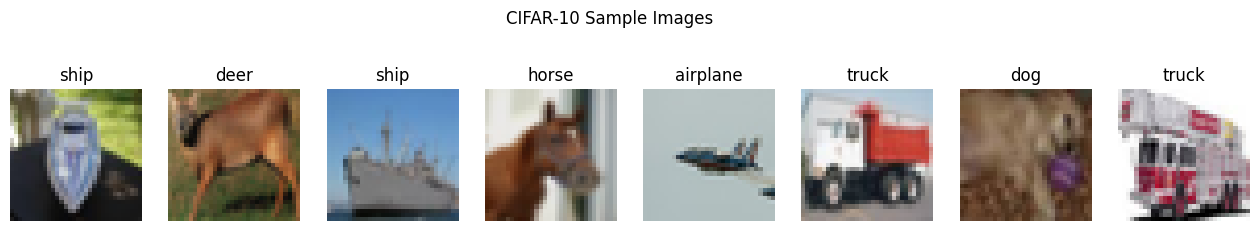

In [5]:
# Class names
classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Get one batch of images
images, labels = next(iter(train_loader))

#Plot the samples

fig,axes=plt.subplots(1,8,figsize =(16,3))

for i,ax in enumerate(axes):
    img=images[i].permute(1,2,0) # (C,H,W) -> (H,W,C)
    ax.imshow(img)
    ax.set_title(classes[labels[i].item()])
    ax.axis("off")

plt.suptitle("CIFAR-10 Sample Images")
plt.show()

## Task 1: Architectural Design


In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=4,stride=2,padding=1),  # (B, 32, 16, 16)
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=4,stride=2,padding=1), # (B, 64, 8, 8)
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1), # (B, 128, 4, 4)
            nn.ReLU()
        )

        self.fc=nn.Linear(128*4*4,2*latent_dim)

    def forward(self,x):
        h=self.conv(x)
        h=h.view(h.size(0),-1)
        mean,logvar = torch.chunk(self.fc(h), 2, dim=1)

        return mean, logvar


def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std


In [7]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        # Latent → feature map
        self.fc = nn.Linear(latent_dim, 512 * 4 * 4)

        self.deconv = nn.Sequential(
            # (B, 512, 4, 4) → (B, 256, 8, 8)
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            # (B, 256, 8, 8) → (B, 128, 16, 16)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            # (B, 128, 16, 16) → (B, 64, 32, 32)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            # 🔧 refinement at full resolution
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),

            # Output RGB image
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 512, 4, 4)
        x = self.deconv(x)
        return torch.sigmoid(x)


### Generate encoder and decoder summary

In [8]:
latent_dimension=128
encoder=Encoder(latent_dimension).to(device)

summary(encoder,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]           1,568
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          32,832
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]         131,200
              ReLU-6            [-1, 128, 4, 4]               0
            Linear-7                  [-1, 256]         524,544
Total params: 690,144
Trainable params: 690,144
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.22
Params size (MB): 2.63
Estimated Total Size (MB): 2.87
----------------------------------------------------------------


In [9]:
decoder=Decoder(latent_dimension).to(device)

summary(decoder,input_size=(latent_dimension,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 8192]       1,056,768
   ConvTranspose2d-2            [-1, 256, 8, 8]       2,097,408
              ReLU-3            [-1, 256, 8, 8]               0
   ConvTranspose2d-4          [-1, 128, 16, 16]         524,416
              ReLU-5          [-1, 128, 16, 16]               0
   ConvTranspose2d-6           [-1, 64, 32, 32]         131,136
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,928
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,928
             ReLU-11           [-1, 64, 32, 32]               0
           Conv2d-12            [-1, 3, 32, 32]           1,731
Total params: 3,885,315
Trainable params: 3,885,315
Non-trainable params: 0
---------------------------

# Task 2: Training and Performance

In [10]:
# Log probability of a diagonal Gaussian distribution
def log_norm_pdf(sample,mean,logvar,dim=1):
    log2pi=math.log(2.*math.pi)
    return torch.sum(
        -0.5*((sample-mean)**2*torch.exp(-logvar)+logvar+log2pi),dim=1
    )


# Beta Annealing method
def beta_anneal(epoch,anneal_epoch):
    """
    Linearly increase beta 0->1
    """
    return min(1.0,epoch/anneal_epoch)


#Compute the loss
def elbo_computation(encoder,decoder,x,beta):

    #Encode

    mean,logvar=encoder(x)

    #Reparametrization trick
    z = reparameterize(mean,logvar)
    

    #decode
    x_logits = decoder(z)  # (B, 3, 32, 32)

    #Reconstruction Term
    recon_loss = F.l1_loss(x_logits,  # convert to [0,1]
    x,    reduction="none")

    logpx_z=-torch.sum(recon_loss,dim=[1,2,3])

    # KL divergence terms

    logpz=log_norm_pdf(z, torch.zeros_like(z), torch.zeros_like(z))
    logqz_x=log_norm_pdf(z, mean, logvar)

    #Negative ELBO (for minimization)
    # beta=1

    return -torch.mean(logpx_z + beta*(logpz - logqz_x)),z



In [11]:
def reset_metrics():
    return 0.0, 0


def update_metric(total_loss, count, loss, batch_size):
    return total_loss + loss.item() * batch_size, count + batch_size

#training function
def train_step(encoder,decoder,images,optimizer,beta):
    encoder.train()
    decoder.train()
    optimizer.zero_grad()
    loss,z=elbo_computation(encoder,decoder,images,beta)
    loss.backward()
    optimizer.step()

    return loss.item()

#Function to print the generated images
def generate_and_display_images(decoder,noise):
    decoder.eval()

    with torch.no_grad():
        images= decoder(noise)
        # images = torch.sigmoid(images)  # convert logits to [0,1]

        images=images.cpu()
        n = min(images.size(0), 8) 
        fig = plt.figure(figsize=(16, 2))
        for i in range(n):
            plt.subplot(1, 8, i + 1)
            img = images[i].permute(1, 2, 0)  # (C,H,W) → (H,W,C)
            plt.imshow(img)
            plt.axis("off")

        plt.show()

#function to plot the trainin and test curve
def plot_training_curves(train_elbo,test_elbo):
    epochs = range(1, len(train_elbo) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_elbo, label="Training ELBO")
    plt.plot(epochs, test_elbo, label="Test ELBO")

    plt.xlabel("Epoch")
    plt.ylabel("ELBO")
    plt.title("VAE Training Curves")
    plt.legend()
    plt.grid(True)
    plt.show()



In [ ]:
def train_the_vae(encoder,decoder,train_loader,test_loader,optimizer,epochs,latent_dim,device):

    train_elbo_history = []
    test_elbo_history = []
    
    noise1=torch.randn(8,latent_dim).to(device)

    print("\nEight random points from the latent space is made in to images before training\n")
    generate_and_display_images(decoder,noise1)

    for epoch in range(epochs):
        beta=beta_anneal(epoch,epochs)
        print(f'beta->{beta}')
        
        train_loss_sum,train_count=reset_metrics()
        test_loss_sum,test_count=reset_metrics()


        #Train
        for images,_ in train_loader:
            images=images.to(device)
            loss=train_step(encoder,decoder,images,optimizer,beta)
            train_loss_sum,train_count=update_metric(train_loss_sum,
                                                     train_count,torch.tensor(loss),
                                                     images.size(0))
            
        #Test
        encoder.eval()
        decoder.eval()
    
        with torch.no_grad():
            for images,_ in test_loader:
                images=images.to(device)
                loss,noise= elbo_computation(encoder,decoder,images,beta)
                test_loss_sum,test_count=update_metric(
                    test_loss_sum,test_count,loss,images.size(0)
                )
    
        train_elbo=train_loss_sum/train_count
        test_elbo=test_loss_sum/test_count
        train_elbo_history.append(-train_elbo)  # negative ELBO = actual ELBO
        test_elbo_history.append(-test_elbo)
    
        print(
            f"Epoch {epoch+1:03d}:",
            f"Train ELBO {-train_elbo:.3f}",
            f"Test ELBO {-test_elbo:.3f}"
        )
    
        # noise=torch.randn(8,latent_dim).to(device)
        generate_and_display_images(decoder,noise)

    print("\nThe same Eight random points from the latent space is made in to images after training\n")
    generate_and_display_images(decoder,noise1)
    plot_training_curves(train_elbo_history,test_elbo_history)
    

In [13]:
latent_dimension=512
learning_rate =1e-4
epochs =50
encoder=Encoder(latent_dimension).to(device)
decoder=Decoder(latent_dimension).to(device)

optimizer= torch.optim.Adam(list(encoder.parameters())+list(decoder.parameters()),lr=learning_rate)


Eight random points from the latent space is made in to images before training



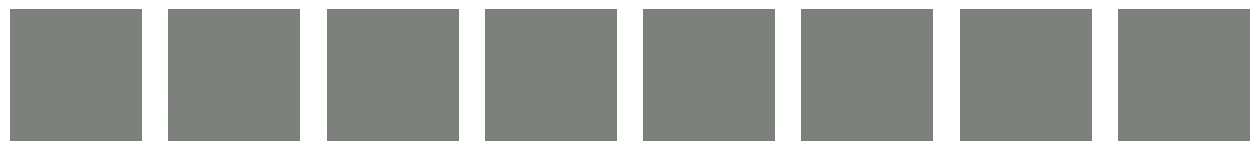

0.0
Epoch 001: Train ELBO -317.573 Test ELBO -234.650


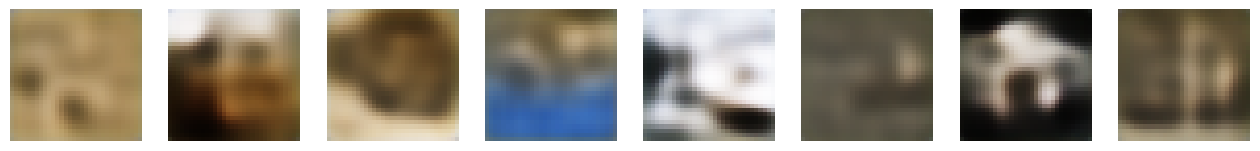

0.02
Epoch 002: Train ELBO -241.333 Test ELBO -228.982


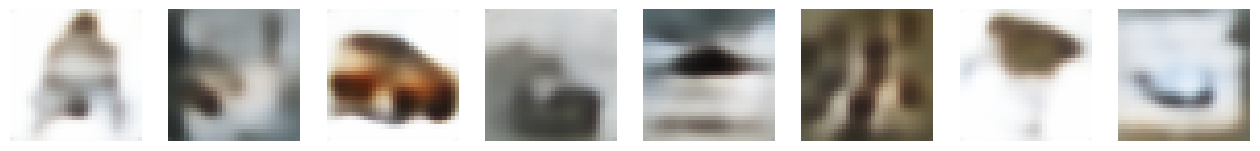

0.04
Epoch 003: Train ELBO -231.639 Test ELBO -222.419


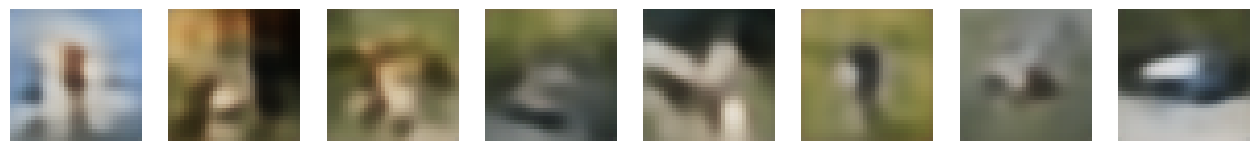

0.06
Epoch 004: Train ELBO -224.294 Test ELBO -212.735


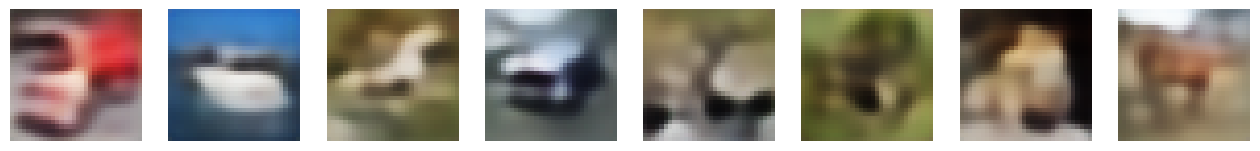

0.08
Epoch 005: Train ELBO -214.755 Test ELBO -207.726


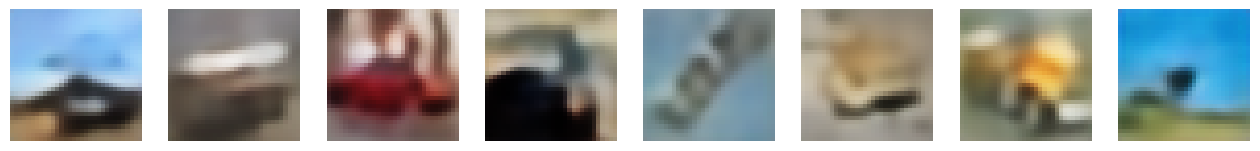

0.1
Epoch 006: Train ELBO -210.638 Test ELBO -204.584


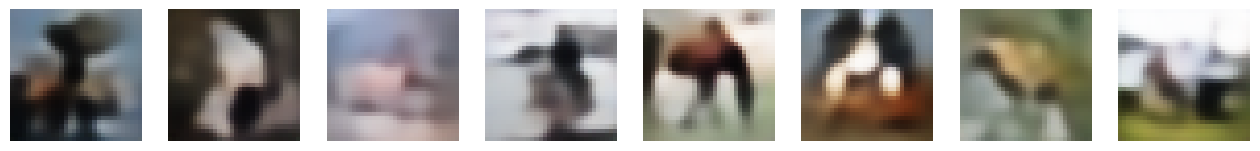

0.12
Epoch 007: Train ELBO -208.746 Test ELBO -204.656


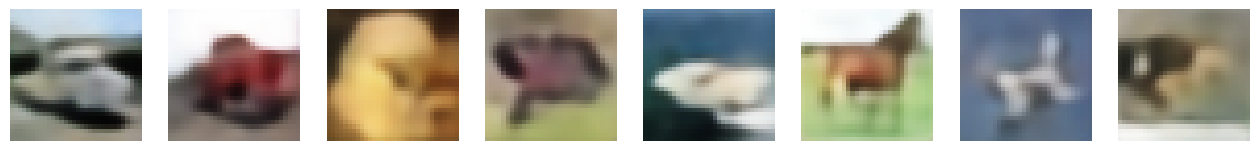

0.14
Epoch 008: Train ELBO -208.250 Test ELBO -206.607


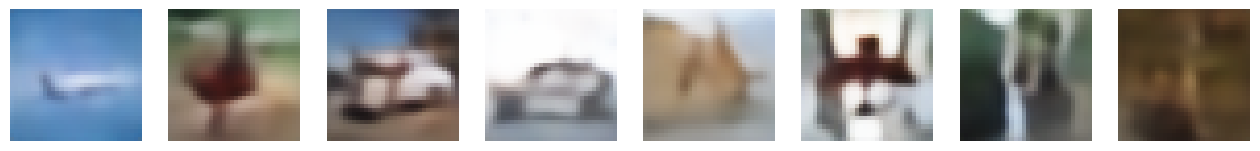

0.16
Epoch 009: Train ELBO -208.294 Test ELBO -205.208


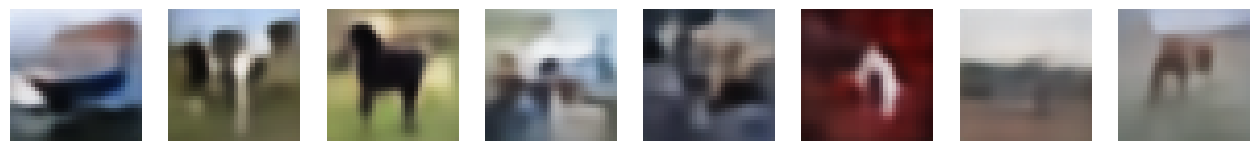

0.18
Epoch 010: Train ELBO -208.851 Test ELBO -207.163


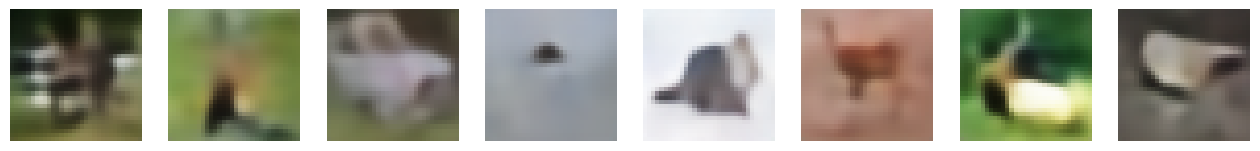

0.2
Epoch 011: Train ELBO -209.994 Test ELBO -213.877


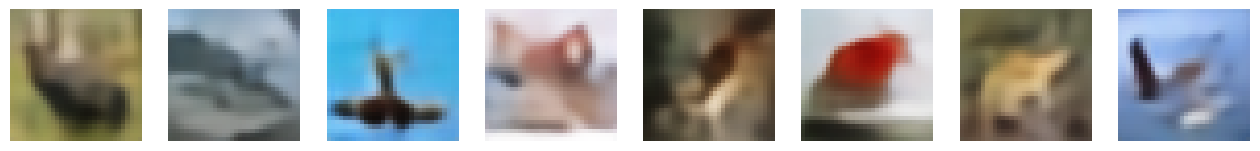

0.22
Epoch 012: Train ELBO -211.455 Test ELBO -213.576


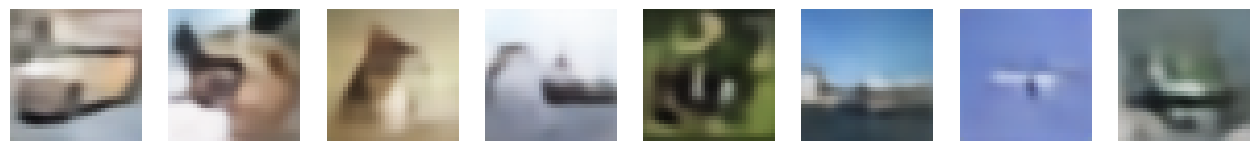

0.24
Epoch 013: Train ELBO -213.087 Test ELBO -213.576


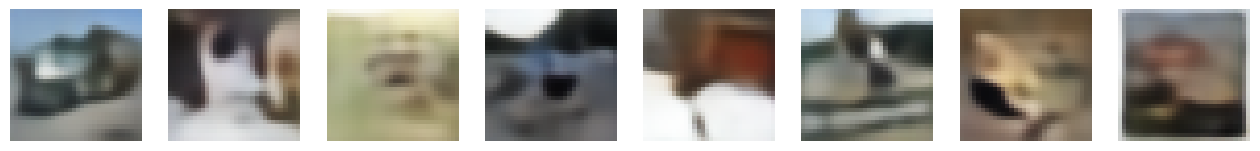

0.26
Epoch 014: Train ELBO -215.181 Test ELBO -214.776


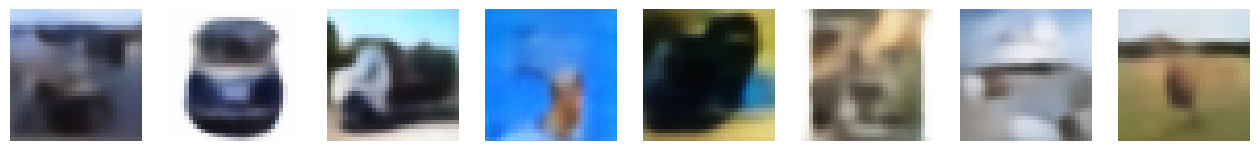

0.28
Epoch 015: Train ELBO -217.201 Test ELBO -217.271


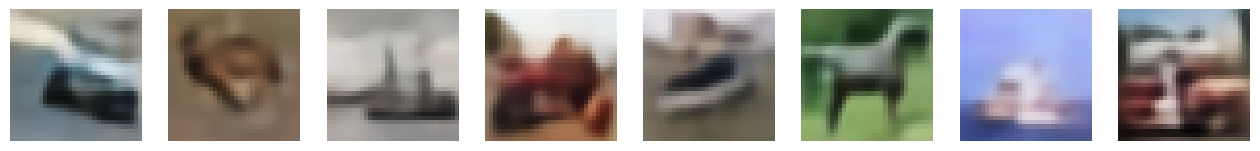

0.3
Epoch 016: Train ELBO -219.225 Test ELBO -219.231


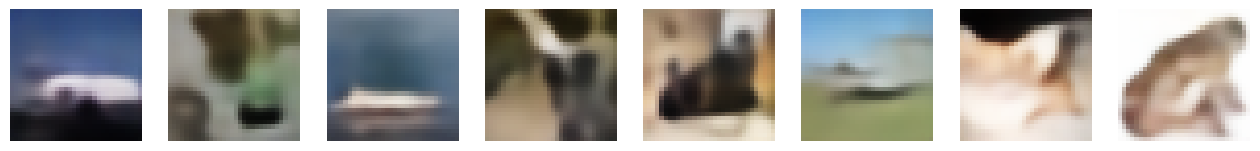

0.32
Epoch 017: Train ELBO -221.482 Test ELBO -222.902


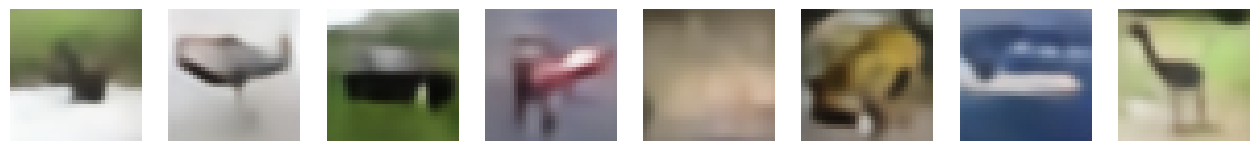

0.34
Epoch 018: Train ELBO -223.617 Test ELBO -224.148


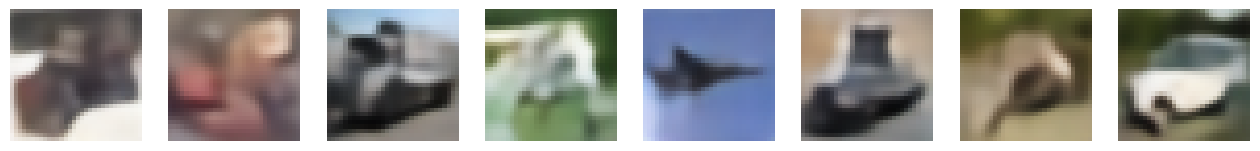

0.36
Epoch 019: Train ELBO -225.804 Test ELBO -226.115


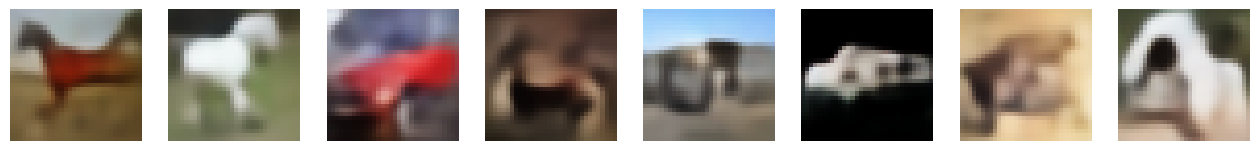

0.38
Epoch 020: Train ELBO -227.906 Test ELBO -228.654


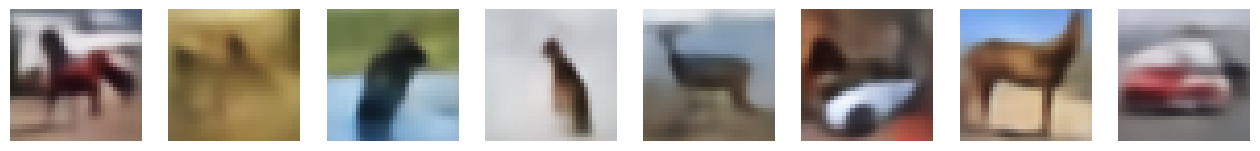

0.4
Epoch 021: Train ELBO -230.107 Test ELBO -232.498


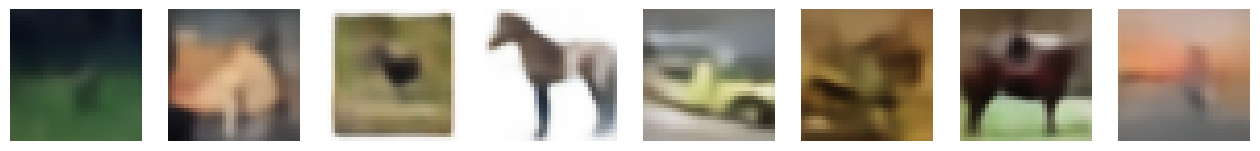

0.42
Epoch 022: Train ELBO -232.268 Test ELBO -232.817


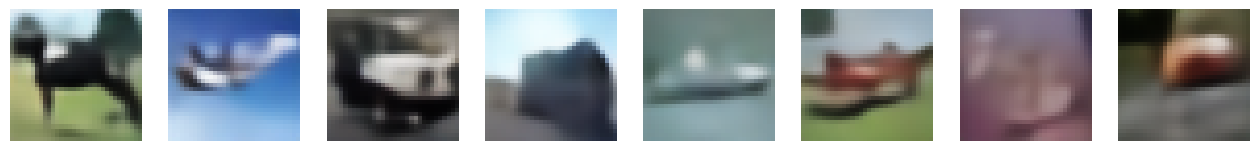

0.44
Epoch 023: Train ELBO -234.296 Test ELBO -235.934


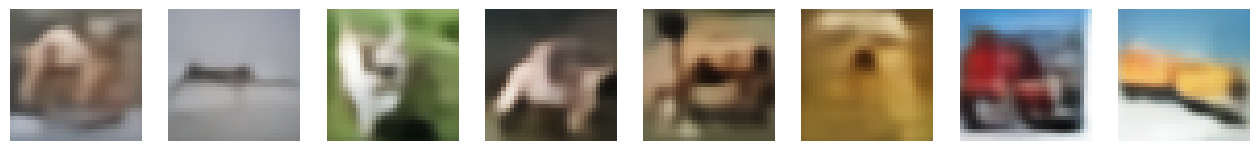

0.46
Epoch 024: Train ELBO -236.346 Test ELBO -238.465


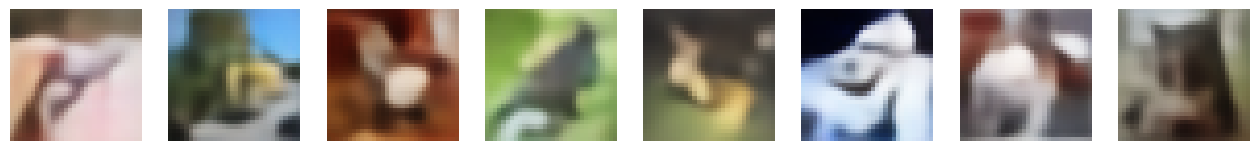

0.48
Epoch 025: Train ELBO -238.319 Test ELBO -240.070


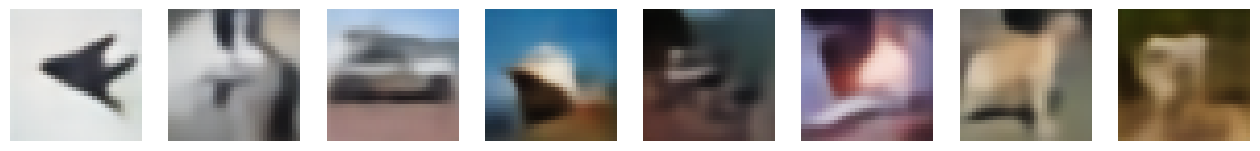

0.5
Epoch 026: Train ELBO -240.310 Test ELBO -242.789


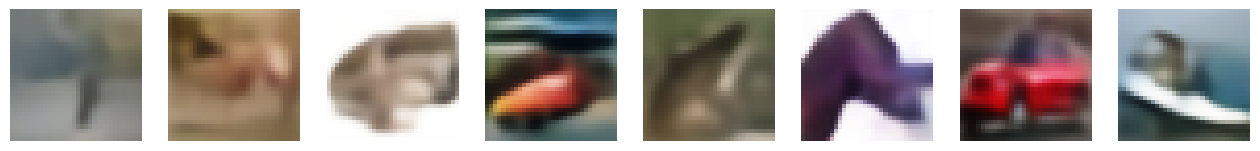

0.52
Epoch 027: Train ELBO -242.303 Test ELBO -244.487


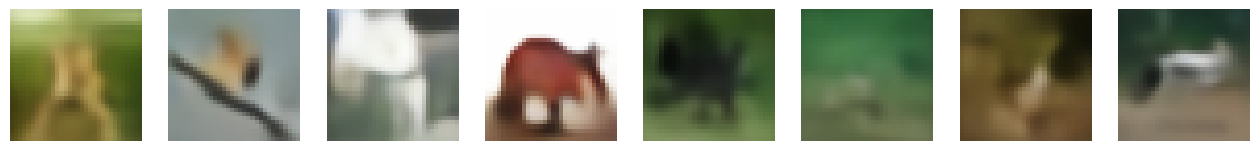

0.54
Epoch 028: Train ELBO -244.089 Test ELBO -245.240


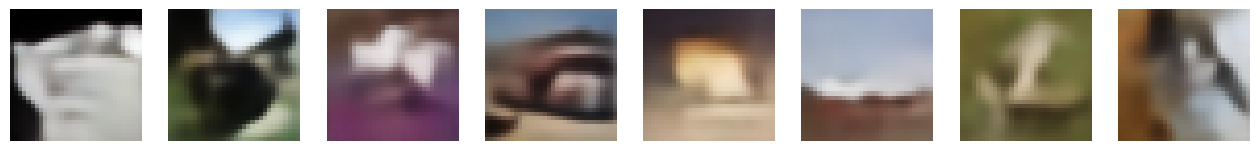

0.56
Epoch 029: Train ELBO -246.000 Test ELBO -248.400


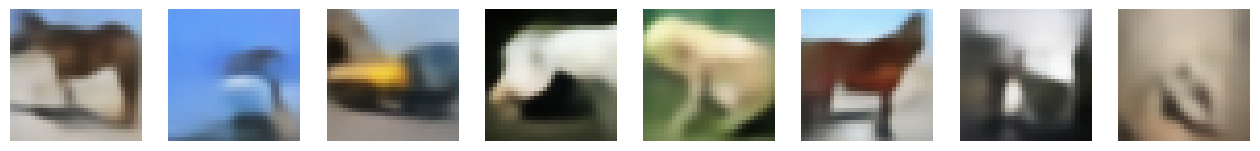

0.58
Epoch 030: Train ELBO -247.734 Test ELBO -249.449


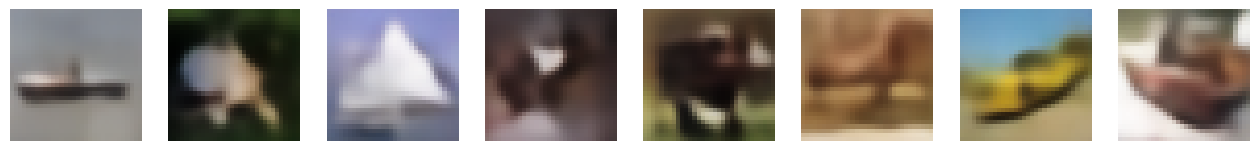

0.6
Epoch 031: Train ELBO -249.559 Test ELBO -251.096


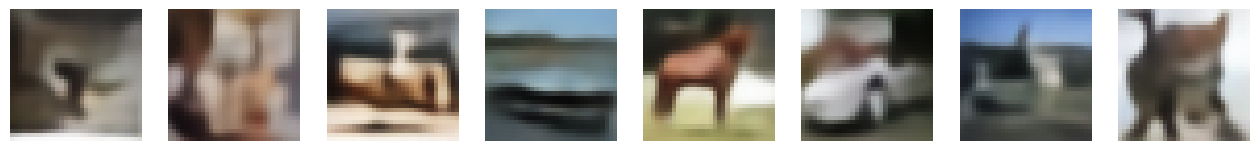

0.62
Epoch 032: Train ELBO -251.296 Test ELBO -253.816


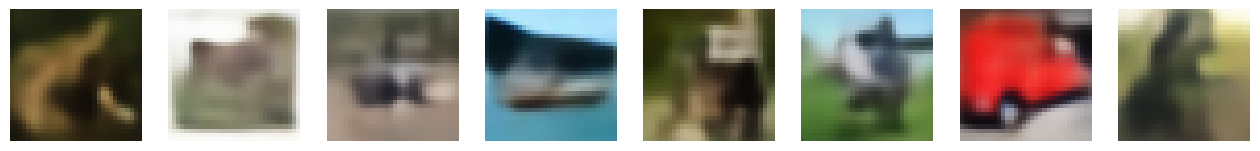

0.64
Epoch 033: Train ELBO -253.016 Test ELBO -255.576


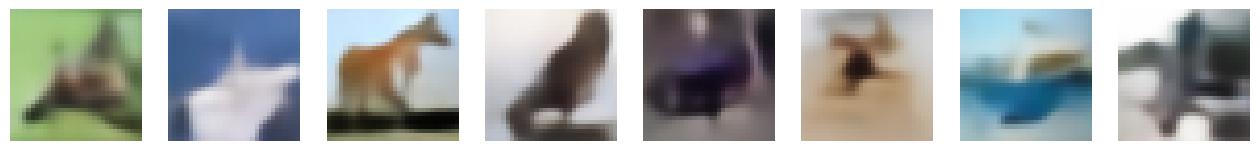

0.66
Epoch 034: Train ELBO -254.590 Test ELBO -257.042


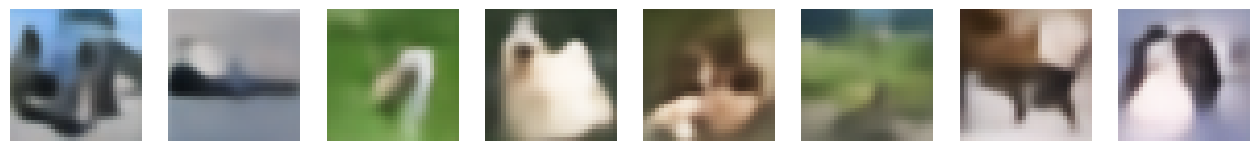

0.68
Epoch 035: Train ELBO -256.254 Test ELBO -258.101


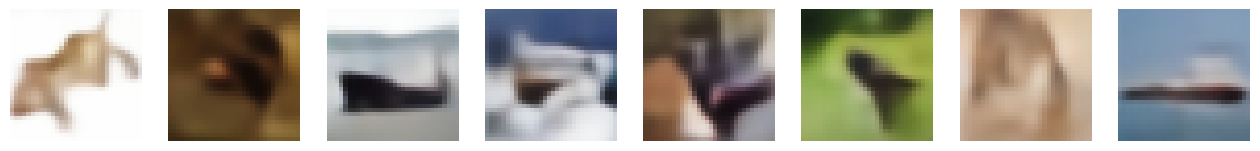

0.7
Epoch 036: Train ELBO -257.869 Test ELBO -259.833


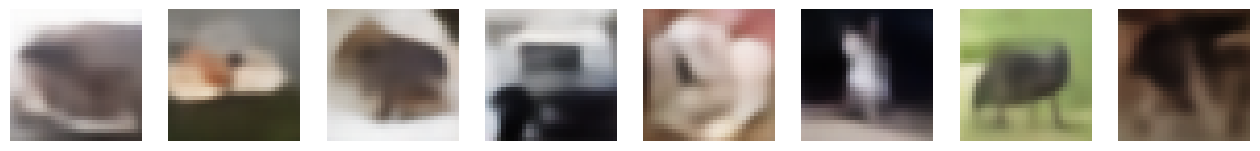

0.72
Epoch 037: Train ELBO -259.379 Test ELBO -261.244


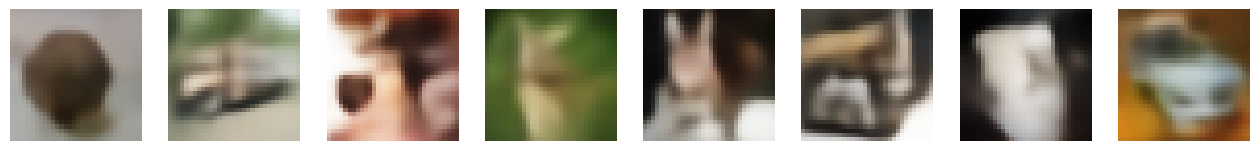

0.74
Epoch 038: Train ELBO -260.867 Test ELBO -263.097


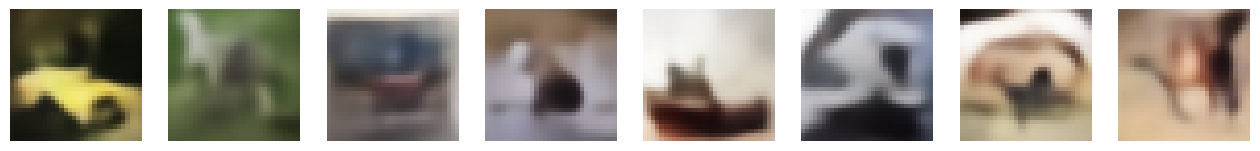

0.76
Epoch 039: Train ELBO -262.366 Test ELBO -263.987


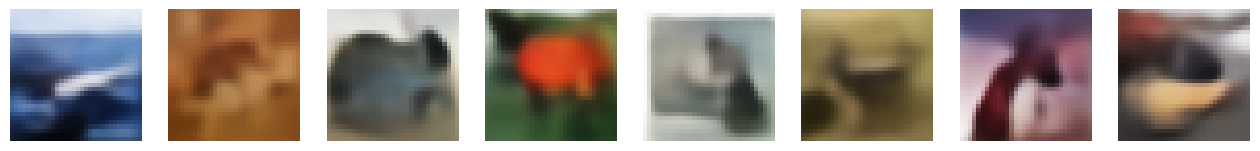

0.78
Epoch 040: Train ELBO -263.800 Test ELBO -268.199


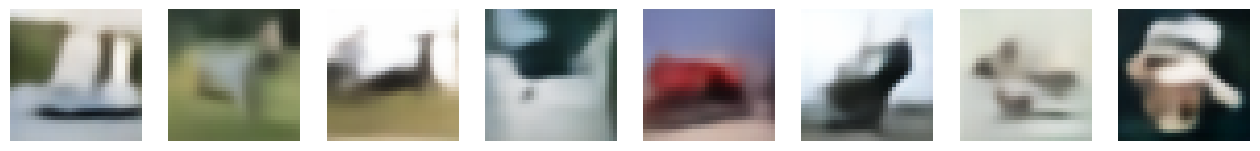

0.8
Epoch 041: Train ELBO -265.259 Test ELBO -267.808


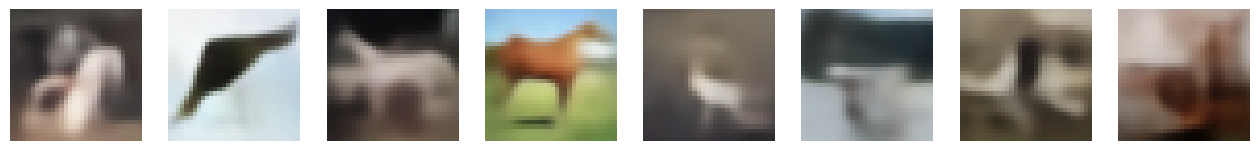

0.82
Epoch 042: Train ELBO -266.635 Test ELBO -268.978


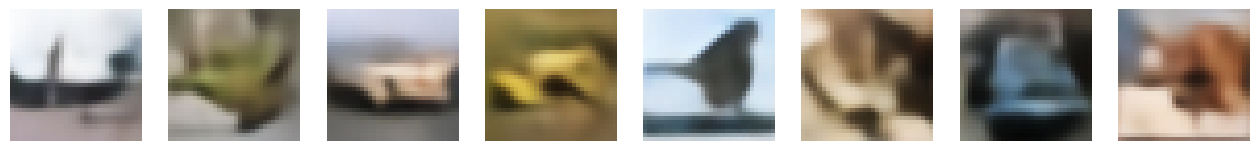

0.84
Epoch 043: Train ELBO -268.078 Test ELBO -270.149


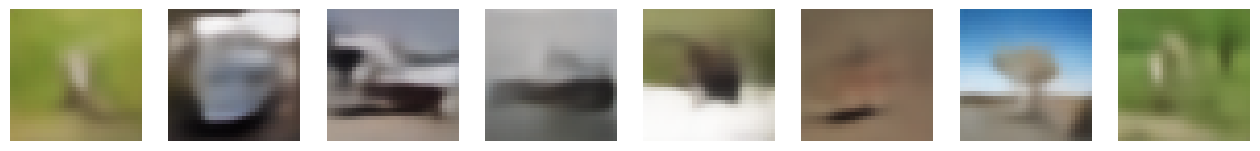

0.86
Epoch 044: Train ELBO -269.388 Test ELBO -271.696


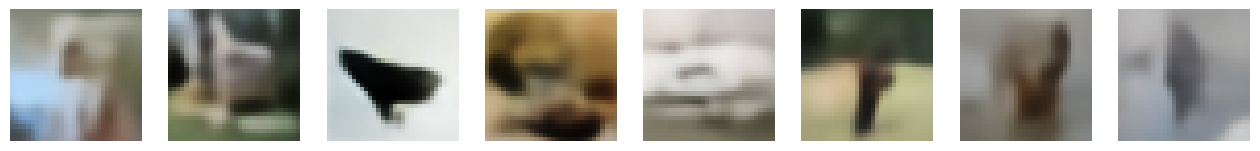

0.88
Epoch 045: Train ELBO -270.760 Test ELBO -273.212


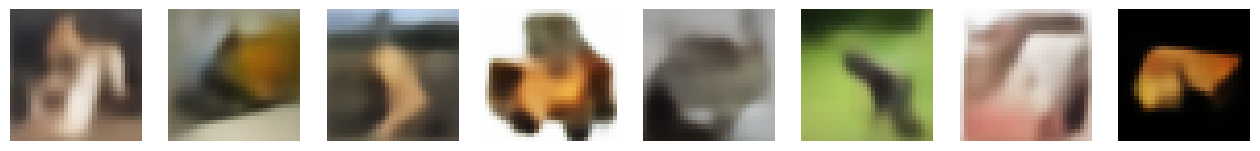

0.9
Epoch 046: Train ELBO -272.094 Test ELBO -274.933


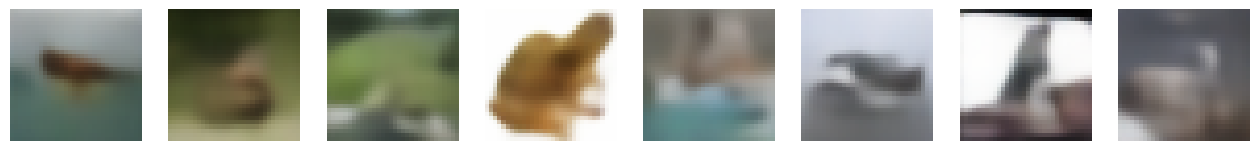

0.92
Epoch 047: Train ELBO -273.351 Test ELBO -276.203


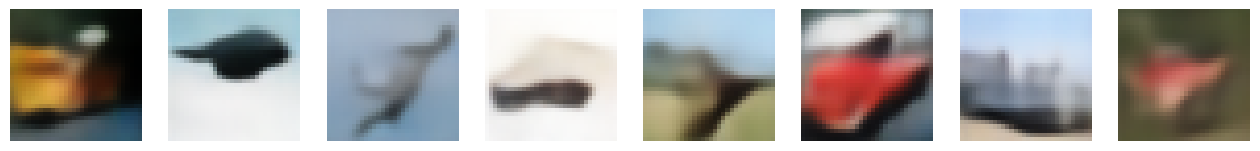

0.94
Epoch 048: Train ELBO -274.676 Test ELBO -277.220


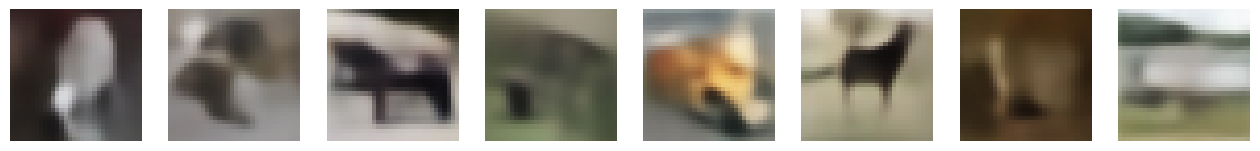

0.96
Epoch 049: Train ELBO -275.883 Test ELBO -278.528


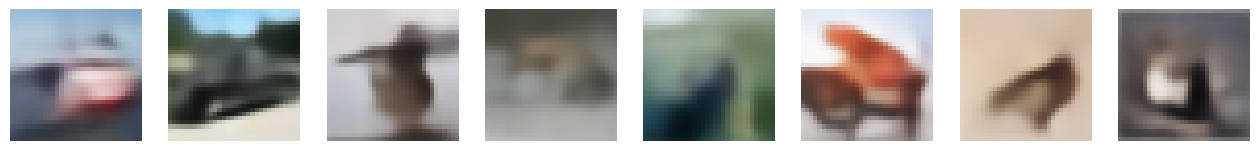

0.98
Epoch 050: Train ELBO -277.161 Test ELBO -280.178


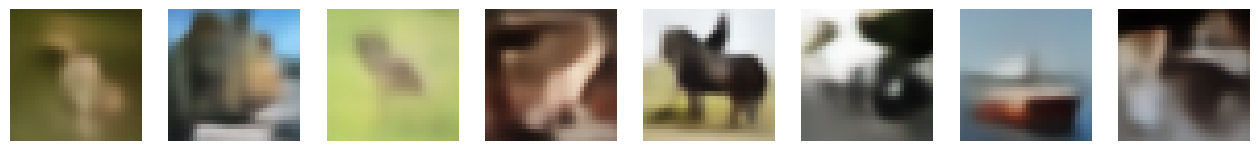


The same Eight random points from the latent space is made in to images after training



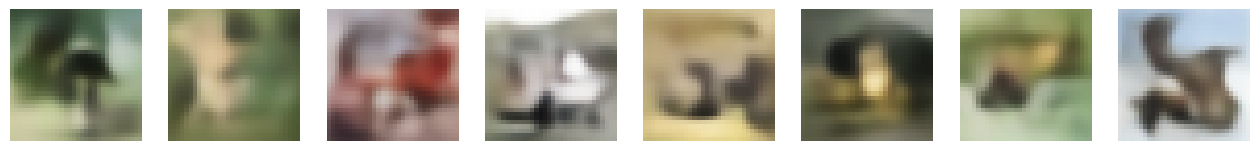

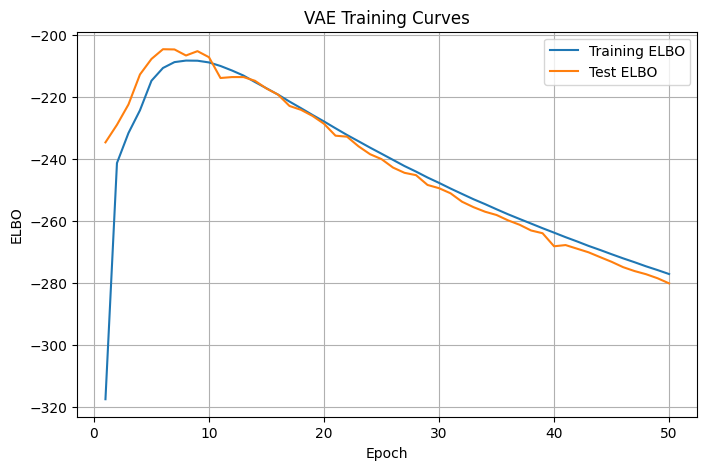

In [14]:
## Here we are using Beta annealing technique in training the model.
train_the_vae(encoder,decoder,train_loader,test_loader,optimizer,epochs,latent_dimension,device)

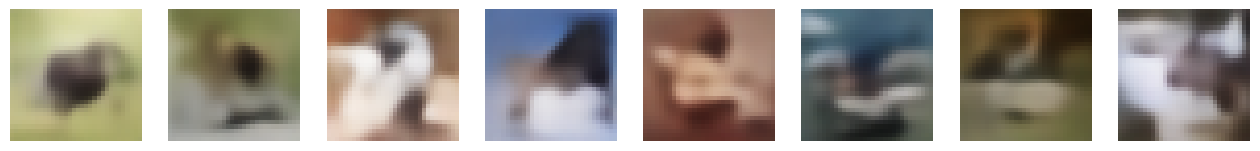

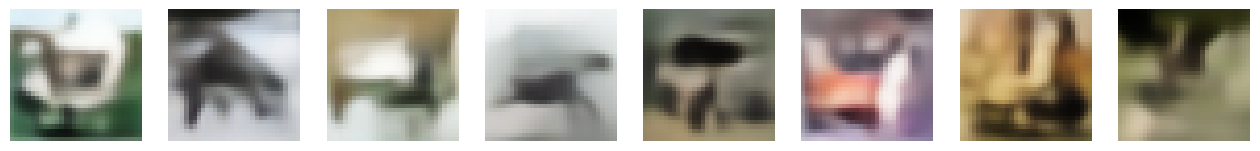

In [15]:
# A generated grid of 16 images ”dreamed up” by the model from random noise.

for i in range(2):
    noise1=torch.randn(8,latent_dimension).to(device)
    generate_and_display_images(decoder,noise1)
    

# Task 3: Latent Space Interpolation

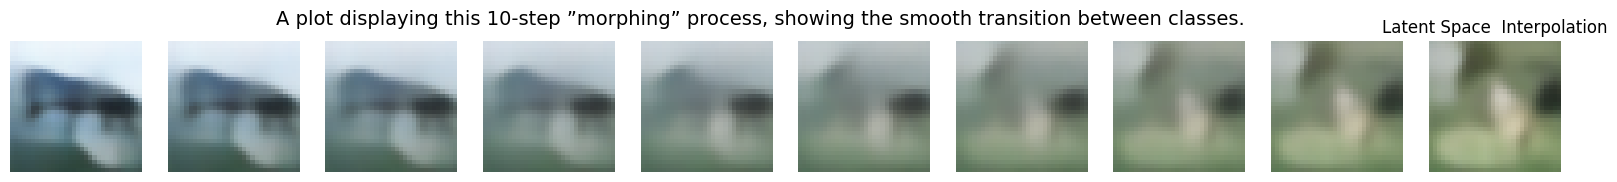

In [ ]:
def interpolate_latents(z1,z2,steps=10):
    return torch.stack(
        [
            (1-alpha)*z1 + alpha*z2
            for alpha in  torch.linspace(0,1,steps)
        ]
    )

def plot_interpolation(images):
    images = images.cpu()

    plt.figure(figsize=(20,2))
    for i in range(images.size(0)):
        plt.subplot(1,images.size(0),i+1)
        img=images[i].permute(1,2,0)   # CHW → HWC
        plt.imshow(img)
        plt.axis("off")
    plt.title("Latent Space  Interpolation")
    plt.suptitle("                                  Latent Space  Interpolation                                    " \
                 "A plot displaying this 10-step ”morphing” process, showing the smooth transition between classes.", fontsize=14)
    plt.show()


encoder.eval()
decoder.eval()

# Sample 2 random points from latent space (prior N(0,1))
z = torch.randn(2, latent_dimension).to(device)

z1 = z[0:1]   # shape (1, latent_dim)
z2 = z[1:2]   # shape (1, latent_dim)

with torch.no_grad():
    
    z_interp=interpolate_latents(z1,z2)
    generated_images=decoder(z_interp)
    plot_interpolation(generated_images)
    

## Task 4: [Advanced] β-VAE Modification

In [20]:

def train_the_vae1(encoder,decoder,train_loader,test_loader,optimizer,epochs,latent_dim,beta,device):

    train_elbo_history = []
    test_elbo_history = []
    
    noise1=torch.randn(8,latent_dim).to(device)
    print("\nThe same Eight random points from the latent space is made in to images before training\n")
    generate_and_display_images(decoder,noise1)
    
    for epoch in range(epochs):
        
        
        
        train_loss_sum,train_count=reset_metrics()
        test_loss_sum,test_count=reset_metrics()


        #Train
        for images,_ in train_loader:
            images=images.to(device)
            loss=train_step(encoder,decoder,images,optimizer,beta)
            train_loss_sum,train_count=update_metric(train_loss_sum,
                                                     train_count,torch.tensor(loss),
                                                     images.size(0))
            
        #Test
        encoder.eval()
        decoder.eval()
    
        with torch.no_grad():
            for images,_ in test_loader:
                images=images.to(device)
                loss,noise= elbo_computation(encoder,decoder,images,beta)
                test_loss_sum,test_count=update_metric(
                    test_loss_sum,test_count,loss,images.size(0)
                )
    
        train_elbo=train_loss_sum/train_count
        test_elbo=test_loss_sum/test_count
        train_elbo_history.append(-train_elbo)  # negative ELBO = actual ELBO
        test_elbo_history.append(-test_elbo)
    
        print(
            f"Epoch {epoch+1:03d}:",
            f"Train ELBO {-train_elbo:.3f}",
            f"Test ELBO {-test_elbo:.3f}"
        )
    
        # noise=torch.randn(8,latent_dim).to(device)
        generate_and_display_images(decoder,noise)

    generate_and_display_images(decoder,noise1)
    print("\nThe same Eight random points from the latent space is made in to images after training\n")
    plot_training_curves(train_elbo_history,test_elbo_history)
    


beta->1

The same Eight random points from the latent space is made in to images before training



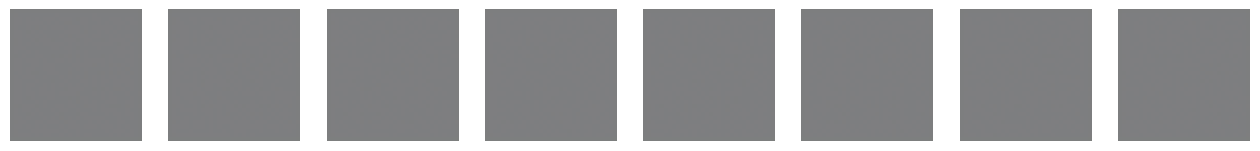

Epoch 001: Train ELBO -441.687 Test ELBO -403.386


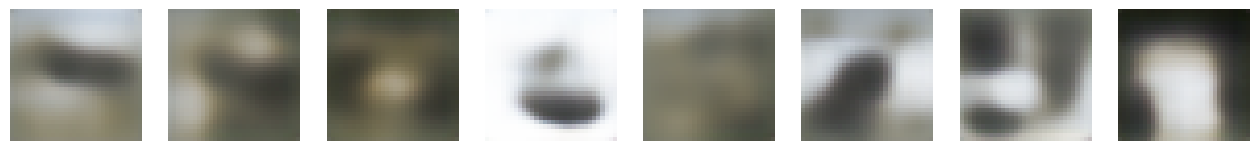

In [ ]:
# train the model for multiple beta values from beta=1 to beta =5
for beta in range(1,6):
    latent_dimension=512
    learning_rate =1e-4
    epochs =20
    encoder=Encoder(latent_dimension).to(device)
    decoder=Decoder(latent_dimension).to(device)
    optimizer= torch.optim.Adam(list(encoder.parameters())+list(decoder.parameters()),lr=learning_rate)
    print(f"beta->{beta}")
    train_the_vae1(encoder,decoder,train_loader,test_loader,optimizer,epochs,latent_dimension,beta,device)

# The effect of β and Extended β training  on VAE behaviour

In this experiment, the model was  first trained  using β annealing technique,i.e gradually increasing  β from 0 to 1. During  the early stages (low β), the model prioritized reconstruction accuracy. The reconstructed images were  sharper  and retained more color intensity  and structural  detail because  the KL-divergence term had  limited influence. As β increased  towards 1,  the regularisation parameter effect progressively strengthened. The latent space  became  smoother and more structured, and interpolation between  latent points appeared more continuous. However, reconstruction  sharpness  gradually decreased as KL constraint  restricted the amount of information encoded in the latent variables

After reaching β=1, additional training was  conducted  using fixed values of β=1,2,3,4 and 5. As β increased beyond 1, the regularization  effect became significantly stronger. The KL divergence  term increasingly dominated the objective function, forcing the learned prosterior closer  to standard normal prior. This resulted in a higly organised  latent space with very smooth interpolations. However reconstruction quality degraded  noticably. Images  become progressively blurrier and  less detailed as β increased, indicating that the encoder  was constrained  from storing fine-grained information.

At higher β vales (4 or 5), over regularisation  was evident. The reconstruction  appeared overly smooth, with reduced  contrast  and weakened  object boundaries. This demonstrates that while  increasing β improves  latent space  regularity and encourages disentanglement, it comes at the cost of  reconstruction fidelity.

Overall the experiment confirm that β  increases, the strength of the regularization increases, leading to  smoother latent representations  but reduced image sharpness